In [2]:
# we're using some funky code for KMeans that throws warnings
# in the lectures they said to just disable warnings 💀
import warnings
warnings.filterwarnings("ignore")

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder() # to convert categorical variables to numbers

# used in Question 1
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set()

# used in Question 2
from apyori import apriori

# used in Question 3
# used in Question 4

# random state
rs: int = 69_420

In [3]:
dataPath = './'

In [4]:
# I like to make this a helper function so that all datasets are implicitly
# loaded the same way
def loadDataset(_filePath: str, encoding: str = "utf-8") -> pd.core.frame.DataFrame:
    absolutePath: str = dataPath + _filePath
    return pd.read_csv(absolutePath, na_filter = False, encoding = encoding)

# because some rows use an empty cell for null
# we have to replacewith null first and then remove them
def dropNaValues(_df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    columnNames: list(str) = _df.columns.tolist()

    for column in columnNames:
        _df[column].replace("", np.nan, inplace=True)
        _df.dropna(subset=[column], inplace=True)

    return _df

# Task 1

## Preprocessing

In [5]:
q1df = pd.read_csv('./Music_shop_v1.csv', encoding='latin-1')

q1df.drop(['ID', 'Type', 'Name'], axis=1, inplace=True)

### Data types & missing values

We need to ensure that the data types instantiated by pandas are of the correct type. We can see that the attributes are loaded with the correct data types as specified by the data description.

We can see one missing value in each attributes:

- Energy
- Loudness
- Instrumentalness


The missing values can be dropped as it is only few of them which will not affect the overall analysis.

In [6]:
q1df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Energy            2979 non-null   float64
 1   Loudness          2979 non-null   float64
 2   Speechiness       2980 non-null   float64
 3   Instrumentalness  2979 non-null   float64
 4   time_signature    2980 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 116.5 KB


In [7]:
q1df.isnull().sum()

Energy              1
Loudness            1
Speechiness         0
Instrumentalness    1
time_signature      0
dtype: int64

In [8]:
print("The shape of the dataset before dropping null values is: ", q1df.shape)
q1df = dropNaValues(q1df)
print("The shape of the dataset after dropping null values is: ", q1df.shape)

The shape of the dataset before dropping null values is:  (2980, 5)
The shape of the dataset after dropping null values is:  (2977, 5)


### Noisy data

One way to quickly check for noisy data is to check for maximum and minimum bounds that an attribute can take.

We know:

- Energy: [0, 1]
- Loudness: [-60, 0]
- Speechiness: [0, 1]
- Instrumentalness: [0, 1]
- time_signature: [0, 5]


Therefore ... errorneous data is found in the following attributes:

- Energy max
- loudness max
- speechiness max
- instrumentalness max

In [9]:
q1df.describe()

,Energy,Loudness,Speechiness,Instrumentalness,time_signature
count,2977.000000,2977.000000,2977.000000,2977.000000,2977.000000
mean,0.536627,-10.893573,0.100936,0.360536,3.886463
std,0.282978,6.753277,0.174708,0.410356,0.492424
min,0.000376,-39.967000,0.000000,0.000000,0.000000
25%,0.277000,-14.628000,0.037500,0.000007,4.000000
50%,0.603000,-8.751000,0.045900,0.024600,4.000000
75%,0.774000,-5.815000,0.074000,0.851000,4.000000
max,1.825000,9.305000,3.073500,1.020900,5.000000


#### Fixation of noisy data for attribute Energy

We have one errornous value.

In [10]:
q1df.drop(q1df[(q1df['Energy'] > 1) | (q1df['Energy'] < 0)].index, inplace=True)


#### Fixation of noisy data for attribute Loudness

In [11]:
index = q1df[(q1df['Loudness'] > 0) | (q1df['Loudness'] < -60)].index

index

Index([164], dtype='int64')

In [12]:
q1df.drop(index, inplace=True)

#### Fixation of noisy data for attribute Speechiness

In [13]:
q1df.drop(q1df[(q1df['Speechiness'] > 1) | (q1df['Speechiness'] < 0)].index, inplace=True)

#### Fixation of noisy data for attribute Instrumentalness

In [14]:
q1df.drop(q1df[(q1df['Instrumentalness'] > 1) | (q1df['Instrumentalness'] < 0)].index, inplace=True)

### Outliers and data distribution

Energy                 Axes(0.125,0.653529;0.227941x0.226471)
Loudness            Axes(0.398529,0.653529;0.227941x0.226471)
Speechiness         Axes(0.672059,0.653529;0.227941x0.226471)
Instrumentalness       Axes(0.125,0.381765;0.227941x0.226471)
time_signature      Axes(0.398529,0.381765;0.227941x0.226471)
dtype: object

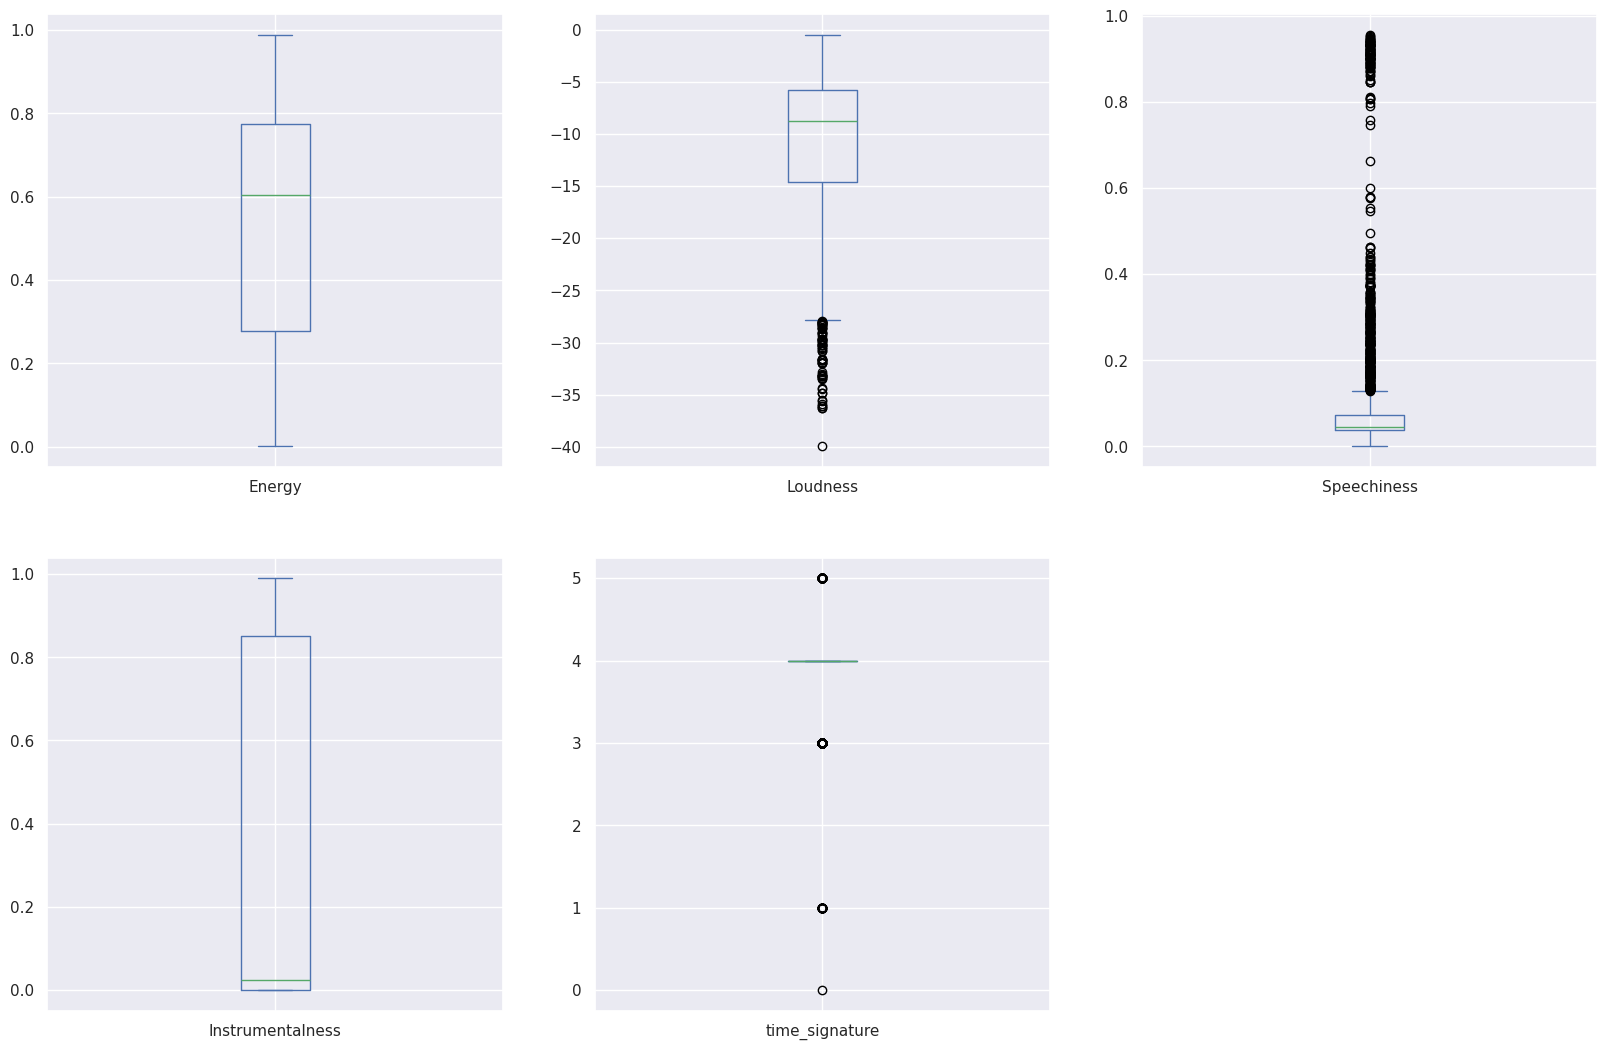

In [15]:
q1df.plot(kind='box', sharex=False, sharey=False, figsize=(20, 20), subplots=True, layout=(3, 3))

## Model

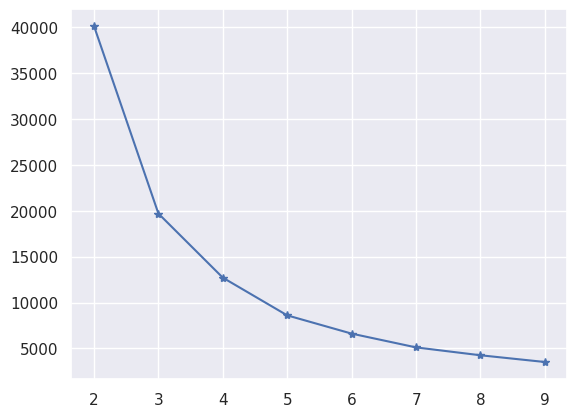

In [16]:
# using an elbow curve to determine the optimal value of "K"
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 10, 1):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(q1df)
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(range(2,10,1), inertia_vals, marker='*')
plt.show()

<Figure size 1500x1000 with 0 Axes>

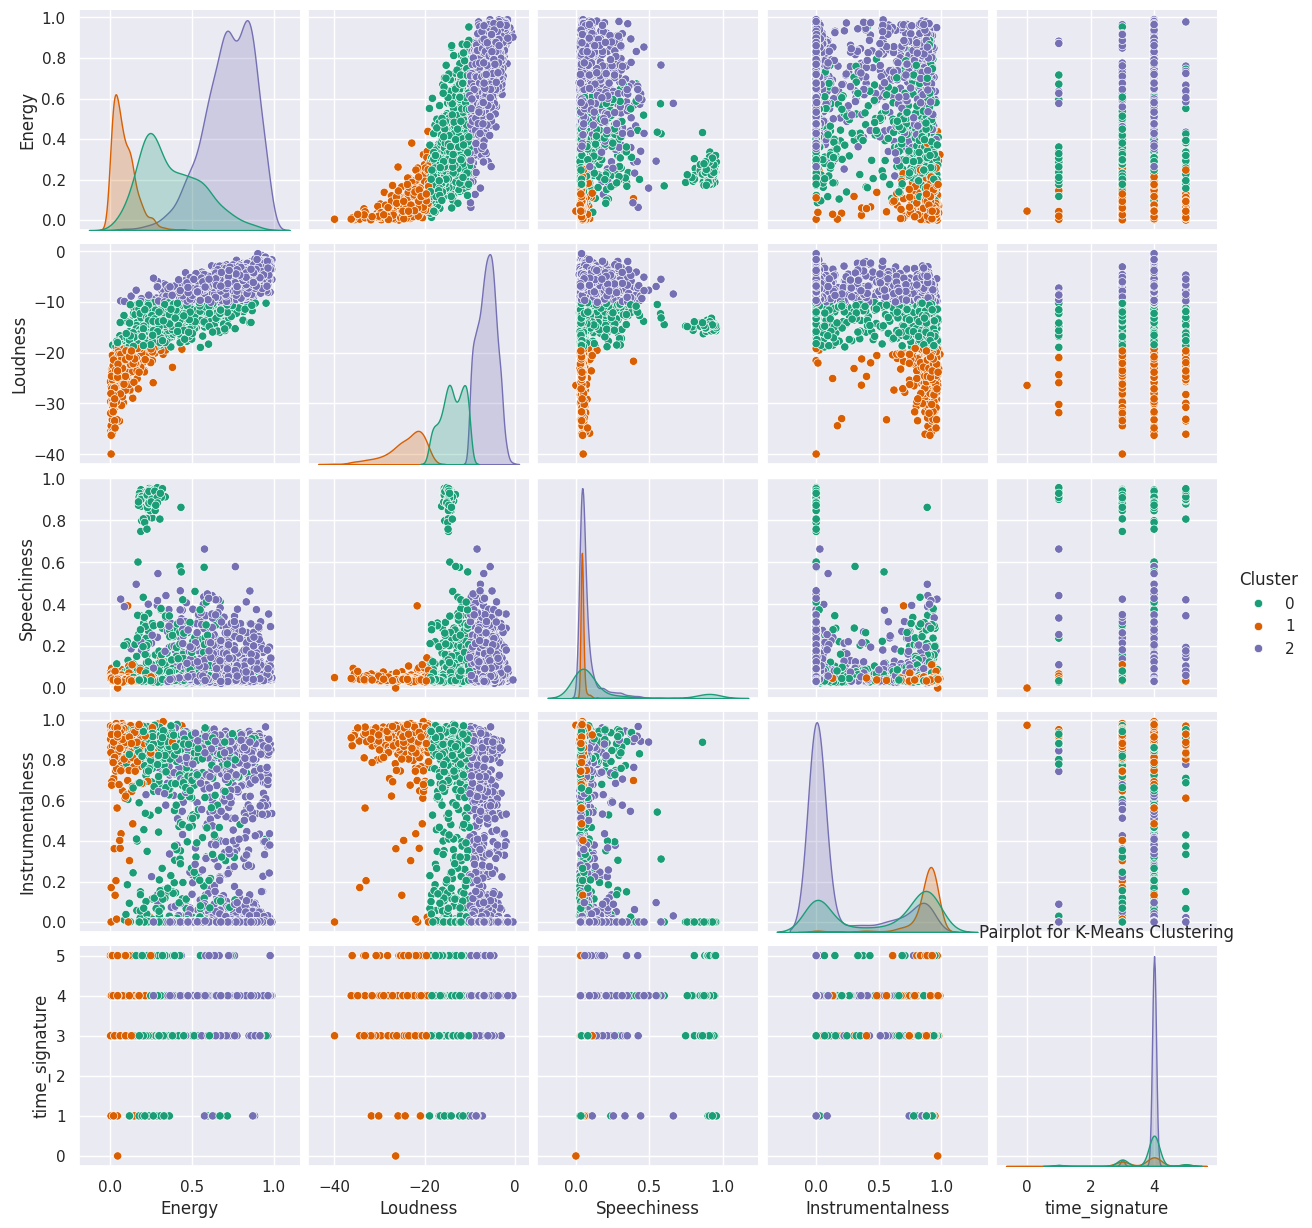

In [23]:
q1Model = KMeans(n_clusters = 3, random_state = rs)
q1Model.fit(q1df)

y = q1Model.predict(q1df)

q1df['Cluster'] = y


plt.figure(figsize=(15, 10))
sns.pairplot(q1df, hue='Cluster', palette='Dark2', diag_kind='kde')
plt.show()